In [24]:
import sys
import os
display("Current working directory: {0}".format(os.getcwd()))
sys.path.append("..")
sys.path.append("../..")
# app_dir = "../NN_feature_interaction"
# sys.path.append(app_dir)
# display("append directory: {0}".format(os.path.abspath(app_dir)))


'Current working directory: /nethome/home3/yuxiang.wu/v6_A-B-C-D-E_Sputtering/CCA_CALPHAD_SSS_ML/CCA_representation_ML/03_Model_Train_Evaluate_Predict'

In [25]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# from path_explain import PathExplainerTF, softplus_activation
from utils.path_explainer_tf import PathExplainerTF
from utils.utils import softplus_activation


In [26]:
# Load California housing dataset
california = fetch_california_housing()
df = pd.DataFrame(california.data, columns=california.feature_names)
df['Target'] = california.target  # Add target column to the dataframe
display(df.head())


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### EDA - correlation matrix


(9, 9)


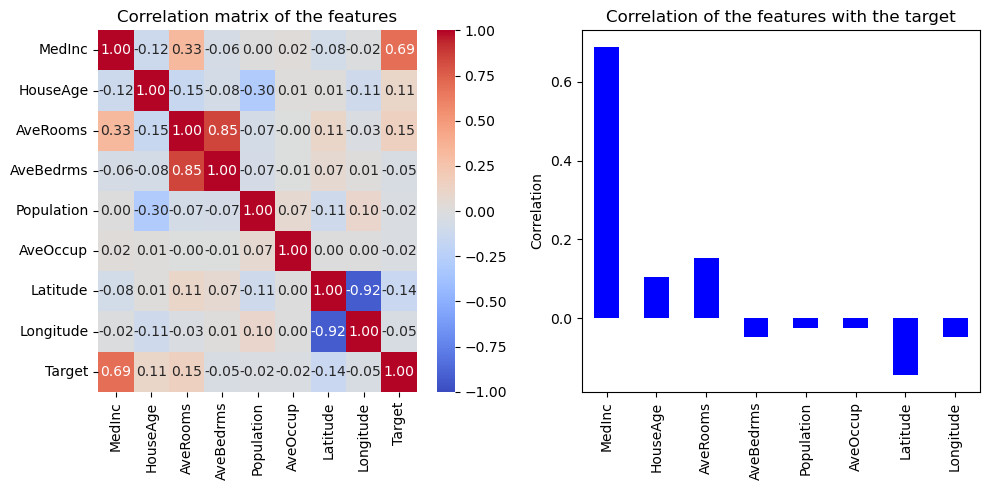

In [27]:
# Compute the correlation matrix
corr_matrix = df.corr()
print(corr_matrix.shape)

plt.figure(figsize=(10, 5))

# Subplot 1 for the correlation heatmap
plt.subplot(1, 2, 1)
sns.heatmap(corr_matrix, annot=True, fmt=".2f",
            cmap='coolwarm', vmax=1, vmin=-1)
plt.title("Correlation matrix of the features")

# Subplot 2 for the correlation of each feature with the target
plt.subplot(1, 2, 2)
df.drop('Target', axis=1).apply(lambda x: x.corr(
    df['Target'])).plot(kind='bar', color='blue')
plt.title("Correlation of the features with the target")
plt.ylabel("Correlation")

plt.tight_layout()
plt.show()

### Model training


In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, BatchNormalization, Concatenate
tf.keras.backend.clear_session()
print(tf.__version__)


# Normalize the data (important for neural networks)
sc = StandardScaler()
X = sc.fit_transform(california.data)
y = california.target

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Define the model


def get_dropout(input_tensor, p=0.5, mc_state=True):

    if mc_state:
        return Dropout(p)(input_tensor, training=True)
    else:
        return Dropout(p)(input_tensor)


def create_model(input_shape, act='relu',  mc_state=False):
    input_layer = tf.keras.layers.Input(shape=input_shape)

    x = tf.keras.layers.Dense(64, activation=act)(input_layer)
    x = get_dropout(x, p=0.1, mc_state=mc_state)
    # x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Dense(128, activation=act)(x)
    x = get_dropout(x, p=0.1, mc_state=mc_state)
    # x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Dense(64, activation=act)(x)
    x = get_dropout(x, p=0.1, mc_state=mc_state)
    # x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Dense(32, activation=act)(x)
    x = get_dropout(x, p=0.1, mc_state=mc_state)
    # x = tf.keras.layers.BatchNormalization()(x)

    output_layer = tf.keras.layers.Dense(1)(x)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model


# model = create_model((X_train.shape[1],), act='relu', mc_state=False)
model = create_model((X_train.shape[1],), act='softplus', mc_state=False)

model.summary()

# Model Compilation: Configures the model for training
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train,
                    epochs=100, verbose=0, validation_data=(X_test, y_test))

# Saving the model
model.save(filepath="shap_NN_model.h5")

# Model prediction
y_test_pred = model.predict(X_test)

2.11.0
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense (Dense)               (None, 64)                576       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)               

129/129 [==============================] - 0s 2ms/step


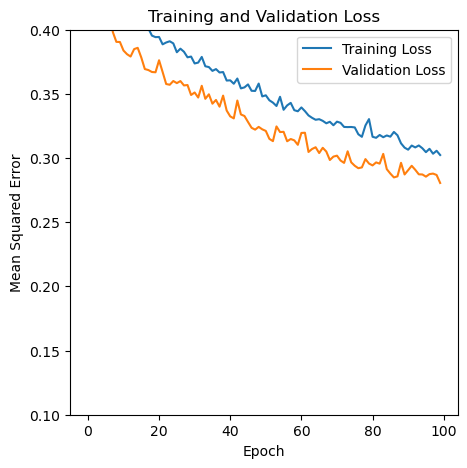

R2 score: 0.7859


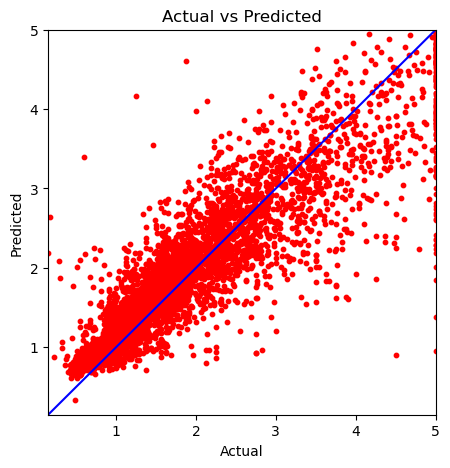

In [29]:
# Plot training and validation loss
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.ylim([0.1, 0.4])
plt.legend()
plt.show()

# Calculate the R2 score
r2 = r2_score(y_test, y_test_pred)
print(f"R2 score: {r2:.4f}")

# Scatter plot of observed vs predicted values
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_test_pred, s=10, color='r')
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.xlim([min(y), max(y)])
plt.ylim([min(y), max(y)])
plt.plot([min(y), max(y)], [min(y), max(y)], color='blue')
plt.show()


In [30]:
model = tf.keras.models.load_model(filepath="shap_NN_model.h5")


## Interpreting the Model: attribution and interaction

The first step in interpreting a ReLU-based model is changing the activations to softplus. The justification for doing this is discussed in the original paper, but in code this is fairly simple to do. First we clone the model, and then we manually change the activation function!


In [43]:
# Clone the model
interpret_model = tf.keras.models.clone_model(model)
interpret_model.compile(optimizer='adam', loss='mean_squared_error')

interpret_model.set_weights(model.get_weights())

# # Loop through layers to change activation functions
# for layer in interpret_model.layers:
#     if hasattr(layer, 'activation'):
#         layer.activation = softplus_activation(beta=10.0)

In [44]:
explainer = PathExplainerTF(interpret_model)


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:01<00:00, 26.83it/s]

(50, 8)


,attributions value,feature
0,-0.443345,MedInc
1,-0.008882,HouseAge
2,-0.052246,AveRooms
3,-0.010205,AveBedrms
4,-0.008992,Population
5,-0.215706,AveOccup
6,-0.549946,Latitude
7,-0.145154,Longitude


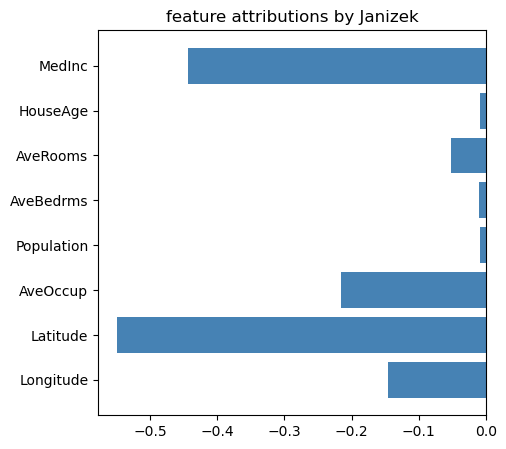

In [45]:
np.random.seed(42)
background_X_indices = np.random.choice(X.shape[0], 50, replace=False)
background_X = X[background_X_indices]

attributions = explainer.attributions(inputs=background_X.astype(np.float32),
                                      baseline=background_X.astype(np.float32),
                                      batch_size=100,
                                      num_samples=200,
                                      use_expectation=True,
                                      output_indices=0,
                                      verbose=True)

print(attributions.shape)
attributions_df = pd.DataFrame(
    data={'attributions value': attributions[0, :], 'feature': california.feature_names})
display(attributions_df)

plt.figure(figsize=(5, 5))
plt.barh(y=attributions_df['feature'],
         width=attributions_df['attributions value'], color='steelblue')
plt.title("feature attributions by Janizek")
plt.gca().invert_yaxis()

In [46]:
# I used the initial model before approximating activation layer
shap_explainer = shap.DeepExplainer(model, background_X)

shap_values_all = shap_explainer.shap_values(background_X)


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


(50, 8)


,shapley value,feature
0,-0.409623,MedInc
1,-0.025973,HouseAge
2,-0.032133,AveRooms
3,-0.008982,AveBedrms
4,-0.016059,Population
5,-0.151991,AveOccup
6,-0.517391,Latitude
7,-0.248459,Longitude


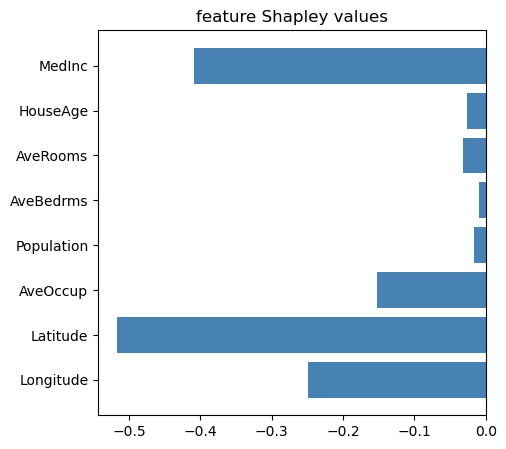

In [47]:
print(shap_values_all[0].shape)

shap_values_df = pd.DataFrame(
    data={'shapley value': shap_values_all[0][0, :], 'feature': california.feature_names})
display(shap_values_df)

plt.figure(figsize=(5, 5))
plt.barh(y=shap_values_df['feature'],
         width=shap_values_df['shapley value'], color='steelblue')
plt.title("feature Shapley values")

plt.gca().invert_yaxis()

In [48]:
interactions = explainer.interactions(inputs=background_X.astype(np.float32),
                                      baseline=background_X.astype(np.float32),
                                      batch_size=100,
                                      num_samples=200,
                                      use_expectation=True,
                                      output_indices=0,
                                      verbose=True)

100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


(50, 8, 8)
(8, 8)
(8, 8)


Text(0.5, 1.0, 'Correlation matrix of the features')

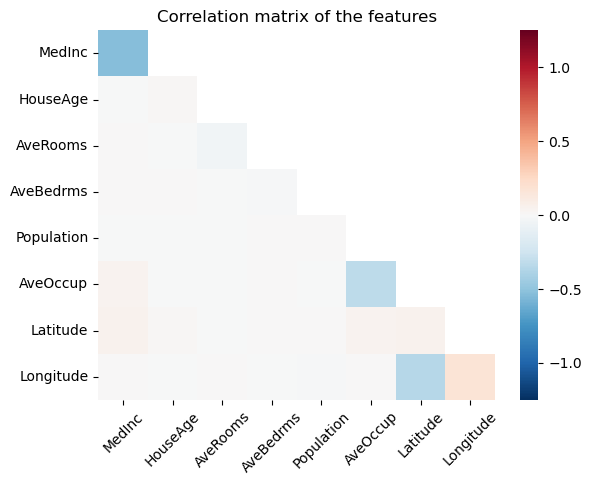

In [49]:
print(interactions.shape)
print(interactions[0].shape)

average_interactions = interactions[0, :, :]
# average_interactions = np.mean(interactions, axis=0)

print(average_interactions.shape)

# Create a mask with True in all the cells. We'll only set the diagonal to False in the next step.
mask = np.triu(np.ones_like(average_interactions, dtype=bool))

# Set the diagonal to False (these are the cells we want to keep)
np.fill_diagonal(mask, False)

ax = sns.heatmap(average_interactions, mask=mask, annot=False, fmt=".2f", cmap='RdBu_r', vmax=1.25, vmin=-1.25,
                 xticklabels=california.feature_names, yticklabels=california.feature_names)
ax.tick_params(axis='x', labelrotation=45)
plt.title("Correlation matrix of the features")

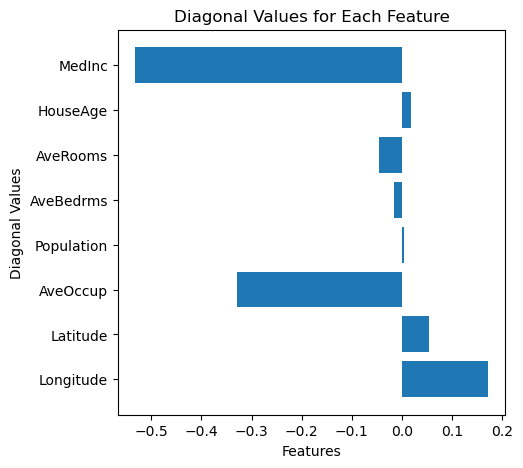

In [50]:
# Extract diagonal values
diagonal_values = np.diag(interactions[0, :, :])

# Get feature names. You already have feature_names from your existing code
# Make sure it has the same length as the diagonal
assert len(california.feature_names) == len(diagonal_values)

# Plotting the bar chart
plt.figure(figsize=(5, 5))
plt.barh(california.feature_names, diagonal_values)
plt.xlabel('Features')
plt.ylabel('Diagonal Values')
plt.title('Diagonal Values for Each Feature')
plt.gca().invert_yaxis()

plt.show()
